In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from GTSRBNet import GTSRBNet
from GTSRBDataset import GTSRBDataset
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
root = ''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))])

validset = GTSRBDataset('valid_us.npz', transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=256,
                                          shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GTSRBNet()
model.to(device)

classes = []
with open(root + 'class_semantics.txt') as f:
    for line in f:
        classes.append(line.strip())

checkpoint = torch.load('checkpoint_us.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GTSRBNet(
  (conv1_1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2_1): Dropout2d(p=0.5, inplace=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3_1): Dropout2d(p=0.5, inplace=False)
  (conv4_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4_1): Dropout2d(p=0.5, inplace=False)
  (fc5_1): Linear(in_features=2048, out_features=1024,

In [3]:
#Helper Functions
def imshow(img):
    img = img + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def saveim(img, name):
    save_image(img, name)
def readim(name):
    image = Image.open(name)
    x = TF.to_tensor(image)
    tform = transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    x = tform(x)
    x.unsqueeze_(0)
    return x

Turn left ahead
34


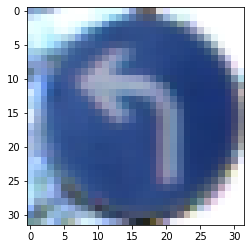

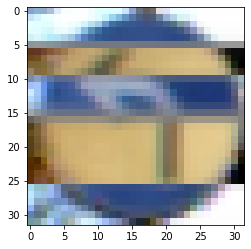

torch.return_types.max(
values=tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([34], device='cuda:0')) torch.return_types.max(
values=tensor([0.9987], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([14], device='cuda:0'))


In [5]:
classidx = 34
o_class = classes[classidx]
print(o_class)
print(classidx)

input_im = readim("orig.png")
xadv = readim("lefttostop.png")
input_im = input_im.cuda()
xadv = xadv.cuda()
out = model(input_im)
outadv = model(xadv)
imshow(input_im[0].cpu())
imshow(xadv[0].cpu())

lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
prob2 = lay2(outadv)
print(prob.max(1), prob2.max(1))

In [16]:
# The input time signal
ft = torch.rand([1,1,36,1], requires_grad=True, dtype=torch.float, device=device)

#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)
lay.to(device)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.ones([1,1,5,1], requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([14], dtype=torch.long, device=device) #stop sign
orig = torch.tensor([classidx], dtype=torch.long, device=device)


lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([ft], lr=lr)
loss_fn = nn.CrossEntropyLoss()



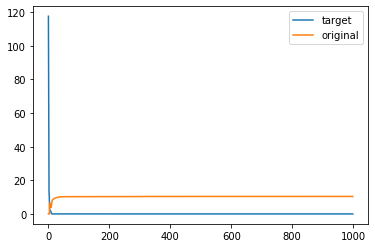

In [27]:
targloss = []
origloss = []
for epoch in range(n_epochs):
    
    # Compute g(y) to get X_adv
    gy = lay(ft)    #Convolution of ft and the shutter
    w = torch.tanh(gy)
    inp = input_im * w           #gy is broadcasted to match the shape of input_im
    out = model(inp)
    
    #Calculate Loss
    loss = loss_fn(out, target)
    targloss.append(loss.data)
    origloss.append(loss_fn(out,orig))
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

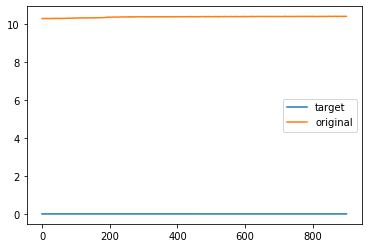

In [28]:
plt.plot(targloss[100:], label="target")
plt.plot(origloss[100:], label="original")
plt.legend()
plt.show()

In [72]:
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
#prob2 = lay2(out2)
prob.max(1)

torch.return_types.max(
values=tensor([0.9988], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([14], device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


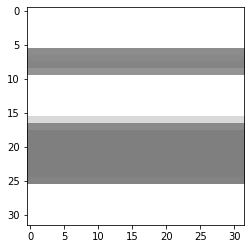

In [73]:
test = torch.ones([1,3,32,32], device=device)
test = test * .5*(w + 1)
imshow(test[0].detach().cpu())

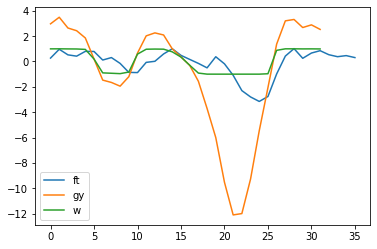

In [74]:
plt.plot(torch.flatten(ft).detach().cpu(), label="ft")
plt.plot(torch.flatten(gy).detach().cpu(), label="gy")
plt.plot(torch.flatten(w).detach().cpu(),label="w")
plt.legend()
plt.show()

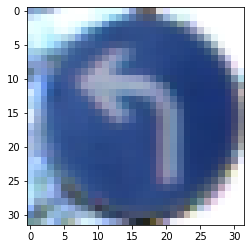

In [67]:
imshow(input_ime.cpu())
saveim(input_ime.cpu() + 0.5, "orig.png")

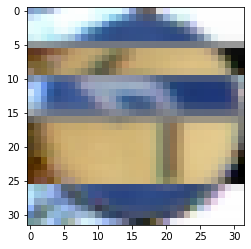

In [71]:
imshow(inp[0].detach().cpu())
saveim(inp[0].detach().cpu() + 0.5, "lefttostop.png")